In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import time
from sklearn import decomposition
from sklearn import preprocessing
from functions import *
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder
import matplotlib as mpl

In [2]:
pd.set_option("display.max_columns",100)
pd.set_option("display.max_rows",250)
pd.set_option('display.max_colwidth',None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
mpl.rcParams['agg.path.chunksize'] = 10000

# GOAL : 
Public Health Agency France request to create innovative project in relation with Food. The Goal of this project is to imagine a project, from OpenFoodFact Dataset. it's about analyzing dataset to conclude on a result.This result was used in order to support the creation of this new project.
The Projet separate into 3 parts: 
- Notebook1: 
    - First Checking 
    - First Cleaning Dataset (reduce the size of dataset & useless data)
    - Create new feature (fruit/vegetable)
    - Impute NaN by IterativeImputer
    - Drop aberrant value
- Notebook2 :
    - Univariate Analysis (data profiling)
    - Bivariate Analysis (ANOVA/boxplot,scatterplot)
    - Multivariate Analysis (ACP)
    

The innovative project defined is to create a application which calculate the nutriscore from characteritics of product.   
We need only scan the informations about this produit from **nutritional value for 100g**.   
Starting from this informations, we can also classify the produit by category, country and suggest to take a better product.



link:https://www.nutrisens.com/vitalites/nutrition-sante/comment-decrypter-les-valeurs-nutritionnelles/#:~:text=Les%20valeurs%20nutritionnelles%20sont%20une,%C3%A9galement%20de%20vitamines%20et%20min%C3%A9raux


### Fonction print_row_col

In [3]:
# This fonction allows to print with histograms the pourcentage of data available in dataset,
# by columns or by rows (depending parameters).
# 0 if you want print by columns, and 1 if you want print by rows.
def print_row_col(row_col,df):
    fig = plt.figure()
    if(row_col==1):
        #for each row, we have ...
        pourcentage=1-(df.isna().sum(axis=1)/df.shape[1])
        plt.hist(pourcentage, bins=df.shape[1])
        plt.title('Pourcentage of data available by products (each rows) ')
    else:
        #for each characteristics, we have ...
        pourcentage=1-(df.isna().sum()/df.shape[0])
        plt.hist(pourcentage)
        plt.title('Pourcentage of data available by characteristics (each columns)  ')
    
    return pourcentage

### 1. Open CSV with Chunk (Large dataset 4Gb)
test with chunksize equal to 1M and 100k. 100k>1M (1min vs 57s)
#### telecharger le dataset sur https://world.openfoodfacts.org/data et changer l'emplacement dans readcsv

In [4]:
start = time.time()
#read data in chunks of 1 million rows at a time
df_chunk =pd.read_csv(r"../../../../Documents/ML_Dataset/en.openfoodfacts.org.products.csv", error_bad_lines=False,sep='\t', chunksize=100000, low_memory=False)
end = time.time()
print("Read csv with chunks: ",(end-start),"sec")

Read csv with chunks:  0.009008169174194336 sec


In [5]:
start = time.time()
pd_df = pd.concat(df_chunk)
end = time.time()
print("chunks 100000: ",(end-start),"sec")

chunks 100000:  61.91632103919983 sec


In [6]:
pd_df.head(10)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,packaging_text,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,origins_en,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_en,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en,ingredients_text,allergens,allergens_en,traces,traces_tags,traces_en,serving_size,serving_quantity,no_nutriments,additives_n,additives,additives_tags,additives_en,ingredients_from_palm_oil_n,...,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-dried_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000017,http://world-en.openfoodfacts.org/product/0000000000017/vitoria-crackers,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000000031,http://world-en.openfoodfacts.org/product/0000000000031/cacao,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,130 g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,000000000003327986,http://world-en.openfoodfacts.org/product/000000000003327986/filetes-de-pollo-empanado,kiliweb,1574175736,2019-11-19T15:02:16Z,1574175737,2019-11-19T15:02:17Z,Filetes de pollo empanado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:es,en:spain,Spain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000000100,http://world-en.openfoodfacts.org/product/0000000000100/moutarde-au-mout-de-raisin-courte-paille,del51,1444572561,2015-10-11T14:09:21Z,1444659212,2015-10-12T14:13:32Z,moutarde au moût de raisin,NaN,100g,NaN,NaN,NaN,courte paille,courte-paille,"Epicerie, Condiments, Sauces, Moutardes","en:groceries,en:condiments,en:sauces,en:mustards","Groceries,Condiments,Sauces,Mustards",NaN,NaN,NaN,NaN,NaN,Delois france,fr:delois-france,fr:delois-france,NaN,NaN,NaN,NaN,NaN,NaN,courte paille,France,en:france,France,eau graines de téguments de moutarde vinaigre de vin rouge sel vin rouge sucre moût de raisin (6.2%) oignons colorants extraits de carotte et extrait de paprika huile de tournesol son de moutarde sel (cette _moutarde_ uniquement disponible chez courte paille),en:mustard,

In [7]:
pd_df.shape

(1555491, 183)

The Goal of this analysis is gather data with aim to design application for heath.  
In this first part, the dataset will be filtered with aim to keep relevant information about each produit.  

## 2. Surface exploration : 
What are the dispersion of data available?
- by produit (rows) => A lots of produit have less than 40% of data available. The concentration are between 5% to 40%, with peak at 15%.
- by characteristics (columns) => the availability of each characteristics is very disperse, scatter, with one peak between 0% to 10%. We can conclude that lot of columns is empty.

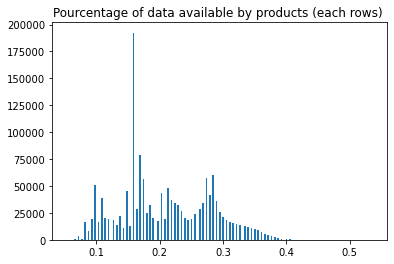

In [8]:
#Pourcentage of data available by products (rows) 
pourcent_row=print_row_col(1,pd_df)

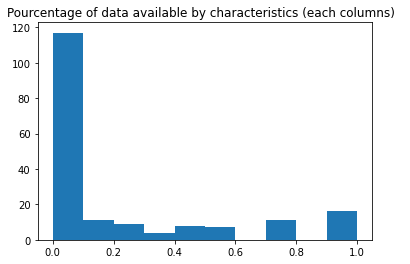

In [9]:
#Pourcentage of data available by characteristics (columns)
pourcent_col=pourcent_row=print_row_col(0,pd_df)

In [10]:
pourcent_col.sort_values()

-melissic-acid_100g                          0.00000
no_nutriments                                0.00000
additives                                    0.00000
ingredients_from_palm_oil                    0.00000
ingredients_that_may_be_from_palm_oil        0.00000
-lignoceric-acid_100g                        0.00000
cities                                       0.00000
-elaidic-acid_100g                           0.00000
-gondoic-acid_100g                           0.00000
allergens_en                                 0.00000
-erucic-acid_100g                            0.00000
-nervonic-acid_100g                          0.00000
water-hardness_100g                          0.00000
-mead-acid_100g                              0.00000
-dihomo-gamma-linolenic-acid_100g            0.00000
-caproic-acid_100g                           0.00000
-myristic-acid_100g                          0.00000
-montanic-acid_100g                          0.00000
-stearic-acid_100g                           0

In [11]:
pourcent_col.index

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name',
       'generic_name', 'quantity',
       ...
       'carbon-footprint-from-meat-or-fish_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'glycemic-index_100g', 'water-hardness_100g',
       'choline_100g', 'phylloquinone_100g', 'beta-glucan_100g',
       'inositol_100g', 'carnitine_100g'],
      dtype='object', length=183)

### Drop
- personal data
- creation and modification
- image
- useless data for my goal
- Produit_name => NA
I have selected some feature that have an impact on the final result : calculate the nutri-score.
So, I kept some feature in relation with nutrient.

In [12]:
pd_df.drop(columns=['code', 'url','creator','created_t','created_datetime','last_modified_t','last_modified_datetime'], inplace=True)
pd_df.dropna(subset=['product_name'], inplace=True)

In [13]:
pd_df.drop(columns=['packaging_tags','brands','brands_tags','categories_tags','categories_en','labels_tags','labels_en','purchase_places',
'stores','countries_tags','countries_en','states','states_tags','states_en','main_category','image_url','image_small_url','image_ingredients_url','image_ingredients_small_url','image_nutrition_url',
'image_nutrition_small_url'], inplace=True)

In [14]:
#pd_df

## 3. Data Filtering

First, filter data by columns more than 30% data available.  
Second, filter data by rows more than 50% data available.  
The goal is reduce the length of dataset, make it more manageable.  

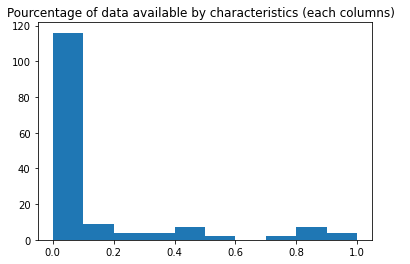

In [15]:
#Pourcentage of data available by characteristics (each columns)
pourcent_col=print_row_col(0,pd_df)

In [16]:
#pourcent_col.sort_values()

In [17]:
#median of features have only 4% of data => more than half of feature are very empty
pourcent_col.median()

0.0024350583357046762

In [18]:
#the fourth quarter have 85% data available
np.percentile(pourcent_col, 75)

0.0973169641042319

### Observation
When we filter columns by more than 30% (we take characterics with more than 30% data), 
- most of them (75% of features) have less than 9% data available
- why 30%? because some of importante features (fiber 100g) have only 30% Data available.

In [19]:
pourcent_col_30=pourcent_col[pourcent_col>0.3]
pourcent_col_30.index

Index(['product_name', 'categories', 'countries', 'ingredients_text',
       'serving_size', 'serving_quantity', 'additives_n',
       'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutriscore_score',
       'nutriscore_grade', 'nova_group', 'pnns_groups_1', 'pnns_groups_2',
       'main_category_en', 'energy-kcal_100g', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g'],
      dtype='object')

In [20]:
pourcent_col_30

product_name                              1.00000
categories                                0.53006
countries                                 0.99752
ingredients_text                          0.44449
serving_size                              0.30212
serving_quantity                          0.30263
additives_n                               0.44449
ingredients_from_palm_oil_n               0.44449
ingredients_that_may_be_from_palm_oil_n   0.44449
nutriscore_score                          0.41647
nutriscore_grade                          0.41647
nova_group                                0.38941
pnns_groups_1                             0.99024
pnns_groups_2                             1.00000
main_category_en                          0.53006
energy-kcal_100g                          0.78993
energy_100g                               0.83459
fat_100g                                  0.82840
saturated-fat_100g                        0.79875
carbohydrates_100g                        0.82794


**df_filtered_1** is the first filtered dataset by more than 30% data available in columns (characteristics) 

In [21]:
df_filtered_1=pd_df.loc[:,pourcent_col_30.index]

In [22]:
df_filtered_1

,product_name,categories,countries,ingredients_text,serving_size,serving_quantity,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutriscore_score,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,main_category_en,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g
0,Vitória crackers,NaN,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,375.00000,1569.00000,7.00000,3.08000,70.10000,15.00000,NaN,7.80000,1.40000,0.56000,NaN
1,Cacao,NaN,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Filetes de pollo empanado,NaN,en:es,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,moutarde au moût de raisin,"Epicerie, Condiments, Sauces, Moutardes",France,eau graines de téguments de moutarde vinaigre de vin rouge sel vin rouge sucre moût de raisin (6.2%) oignons colorants extraits de carotte et extrait de paprika huile de tournesol son de moutarde sel (cette _moutarde_ uniquement disponible chez courte paille),NaN,NaN,0.00000,0.00000,0.00000,18.00000,d,NaN,Fat and sauces,Dressings and sauces,Mustards,NaN,936.00000,8.20000,2.20000,29.00000,22.00000,0.00000,5.10000,4.60000,1.84000,18.00000
4,Sfiudwx,Xsf,en:France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,unknown,fr:xsf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1555486,Scs,NaN,en:gb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,100.00000,418.00000,12.00000,1.00000,2.00000,1.00000,NaN,1.00000,1.00000,0.40000,NaN
1555487,Sandwich club Rillette poisson combava,NaN,en:re,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1555488,Thé noir BIO Darjeeling,NaN,en:france,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1555489,Fati,NaN,en:be,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,24.00000,100.00000,0.30000,0.00000,2.40000,0.60000,NaN,1.60000,0.64000,0.25600,NaN


array([0.11538462, 0.15384615, 0.19230769, 0.23076923, 0.26923077,
       0.30769231, 0.34615385, 0.38461538, 0.42307692, 0.46153846,
       0.5       , 0.53846154, 0.57692308, 0.61538462, 0.65384615,
       0.69230769, 0.73076923, 0.76923077, 0.80769231, 0.84615385,
       0.88461538, 0.92307692, 0.96153846, 1.        ])

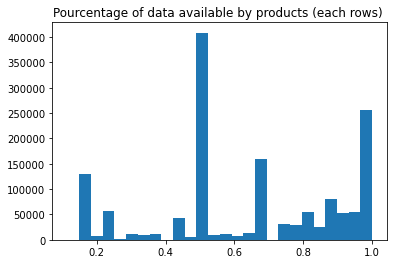

In [23]:
#Pourcentage of data available by products (rows) , more than 
pourcent_row=print_row_col(1,df_filtered_1)
pourcent_row.sort_values().unique()

In [24]:
pourcent_row.median()

0.6923076923076923

### Observation  
50% of features have more than 69% data available.  
For this project, i thinks it's better to have more row in order to have a better analysis to calculate the nutriscore,   
so why i choose to take 50% of data available

In [25]:
pourcent_row_50=pourcent_row[pourcent_row>=0.5]

**df_filtered_2** is the second filtered dataset by more than 30% data available in columns (characteristics), 
and by more than 50% data available in row (product).

In [26]:
df_filtered_2=df_filtered_1.loc[pourcent_row_50.index,:]

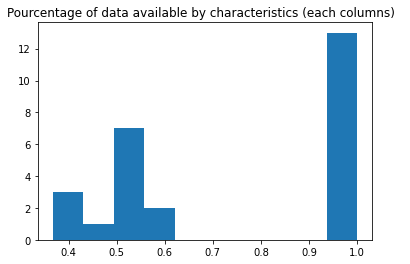

In [27]:
#Pourcentage of data available by chra (col)
pourcent_col=print_row_col(0,df_filtered_2)

In [28]:
pourcent_col.sort_values()

serving_size                              0.36733
serving_quantity                          0.36756
fiber_100g                                0.37632
nova_group                                0.45482
ingredients_text                          0.51140
additives_n                               0.51140
ingredients_from_palm_oil_n               0.51140
ingredients_that_may_be_from_palm_oil_n   0.51140
nutriscore_score                          0.51289
nutrition-score-fr_100g                   0.51289
nutriscore_grade                          0.51289
main_category_en                          0.58495
categories                                0.58496
energy-kcal_100g                          0.94309
saturated-fat_100g                        0.95797
sugars_100g                               0.97848
sodium_100g                               0.98571
salt_100g                                 0.98571
carbohydrates_100g                        0.99503
proteins_100g                             0.99537


## Drop

In [29]:
df_filtered_2.drop(columns=['serving_size','serving_quantity','ingredients_text','ingredients_from_palm_oil_n','ingredients_that_may_be_from_palm_oil_n',
'nutrition-score-fr_100g'], inplace=True)

In [30]:
df_filtered_2

,product_name,categories,countries,additives_n,nutriscore_score,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,main_category_en,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g
0,Vitória crackers,NaN,France,NaN,NaN,NaN,NaN,unknown,unknown,NaN,375.00000,1569.00000,7.00000,3.08000,70.10000,15.00000,NaN,7.80000,1.40000,0.56000
3,moutarde au moût de raisin,"Epicerie, Condiments, Sauces, Moutardes",France,0.00000,18.00000,d,NaN,Fat and sauces,Dressings and sauces,Mustards,NaN,936.00000,8.20000,2.20000,29.00000,22.00000,0.00000,5.10000,4.60000,1.84000
5,Sauce Sweety chili 0%,NaN,France,NaN,NaN,NaN,NaN,unknown,unknown,NaN,21.00000,88.00000,0.00000,0.00000,4.80000,0.40000,NaN,0.20000,2.04000,0.81600
6,Mini coco,NaN,France,NaN,NaN,NaN,NaN,unknown,unknown,NaN,60.00000,251.00000,3.00000,1.00000,10.00000,3.00000,NaN,2.00000,1.15000,0.46000
13,Salade de carottes râpées,"Plats préparés, Légumes préparés, Carottes râpées, Carottes râpées assaisonnées",France,NaN,1.00000,b,NaN,Composite foods,One-dish meals,Seasoned shredded carrots,32.00000,134.00000,0.30000,0.10000,5.30000,3.90000,NaN,0.90000,0.42000,0.16800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1555482,Minis beignets,"Snacks, Snacks sucrés, Beignets sucrés",France,NaN,15.00000,d,NaN,unknown,unknown,Sweet Fritters,333.00000,1393.00000,20.20000,6.00000,30.90000,10.40000,NaN,7.40000,1.10000,0.44000
1555483,Erdbeerkuchen 1019g tiefgefroren,"Kekse und Kuchen, Kuchen, Tiefkühl-Kuchen",Deutschland,2.00000,12.00000,d,4.00000,Sugary snacks,Biscuits and cakes,de:tiefkühl-kuchen,NaN,925.00000,7.60000,4.80000,35.00000,24.00000,NaN,2.60000,0.28000,0.11200
1555484,Steak haché pur boeuf,"Viandes, Bœuf, Steaks, Steaks de bœuf, Steaks hachés, Steaks de bœuf hachés",France,NaN,-2.00000,a,NaN,Fish Meat Eggs,Meat,Ground beef steaks,131.00000,548.00000,5.00000,2.30000,0.00000,0.00000,NaN,21.50000,0.18000,0.07200
1555486,Scs,NaN,en:gb,NaN,NaN,NaN,NaN,unknown,unknown,NaN,100.00000,418.00000,12.00000,1.00000,2.00000,1.00000,NaN,1.00000,1.00000,0.40000


## 4. Separate into 2 datasets for analysis

I thinks it's better to separate the general information about product and nutriscore information.  
This separation allows to make a deepen analysis about nutriscore.
- df_nutriscore : Calculate nutriscore from nutri-score charact
- df_charact: others information about product (categorie,additive, nova group...)

In [31]:
df_charact=df_filtered_2.loc[:,['product_name','categories','countries','additives_n','nutriscore_score','nutriscore_grade','nova_group','pnns_groups_1','pnns_groups_2','main_category_en']]
df_nutriscore=df_filtered_2.loc[:,['product_name','nutriscore_score','nutriscore_grade',"energy-kcal_100g","energy_100g","fat_100g","saturated-fat_100g","carbohydrates_100g","sugars_100g","fiber_100g","proteins_100g","salt_100g","sodium_100g"]]

In [32]:
df_charact

,product_name,categories,countries,additives_n,nutriscore_score,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,main_category_en
0,Vitória crackers,NaN,France,NaN,NaN,NaN,NaN,unknown,unknown,NaN
3,moutarde au moût de raisin,"Epicerie, Condiments, Sauces, Moutardes",France,0.00000,18.00000,d,NaN,Fat and sauces,Dressings and sauces,Mustards
5,Sauce Sweety chili 0%,NaN,France,NaN,NaN,NaN,NaN,unknown,unknown,NaN
6,Mini coco,NaN,France,NaN,NaN,NaN,NaN,unknown,unknown,NaN
13,Salade de carottes râpées,"Plats préparés, Légumes préparés, Carottes râpées, Carottes râpées assaisonnées",France,NaN,1.00000,b,NaN,Composite foods,One-dish meals,Seasoned shredded carrots
...,...,...,...,...,...,...,...,...,...,...
1555482,Minis beignets,"Snacks, Snacks sucrés, Beignets sucrés",France,NaN,15.00000,d,NaN,unknown,unknown,Sweet Fritters
1555483,Erdbeerkuchen 1019g tiefgefroren,"Kekse und Kuchen, Kuchen, Tiefkühl-Kuchen",Deutschland,2.00000,12.00000,d,4.00000,Sugary snacks,Biscuits and cakes,de:tiefkühl-kuchen
1555484,Steak haché pur boeuf,"Viandes, Bœuf, Steaks, Steaks de bœuf, Steaks hachés, Steaks de bœuf hachés",France,NaN,-2.00000,a,NaN,Fish Meat Eggs,Meat,Ground beef steaks
1555486,Scs,NaN,en:gb,NaN,NaN,NaN,NaN,unknown,unknown,NaN


In [33]:
df_nutriscore

,product_name,nutriscore_score,nutriscore_grade,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g
0,Vitória crackers,NaN,NaN,375.00000,1569.00000,7.00000,3.08000,70.10000,15.00000,NaN,7.80000,1.40000,0.56000
3,moutarde au moût de raisin,18.00000,d,NaN,936.00000,8.20000,2.20000,29.00000,22.00000,0.00000,5.10000,4.60000,1.84000
5,Sauce Sweety chili 0%,NaN,NaN,21.00000,88.00000,0.00000,0.00000,4.80000,0.40000,NaN,0.20000,2.04000,0.81600
6,Mini coco,NaN,NaN,60.00000,251.00000,3.00000,1.00000,10.00000,3.00000,NaN,2.00000,1.15000,0.46000
13,Salade de carottes râpées,1.00000,b,32.00000,134.00000,0.30000,0.10000,5.30000,3.90000,NaN,0.90000,0.42000,0.16800
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1555482,Minis beignets,15.00000,d,333.00000,1393.00000,20.20000,6.00000,30.90000,10.40000,NaN,7.40000,1.10000,0.44000
1555483,Erdbeerkuchen 1019g tiefgefroren,12.00000,d,NaN,925.00000,7.60000,4.80000,35.00000,24.00000,NaN,2.60000,0.28000,0.11200
1555484,Steak haché pur boeuf,-2.00000,a,131.00000,548.00000,5.00000,2.30000,0.00000,0.00000,NaN,21.50000,0.18000,0.07200
1555486,Scs,NaN,NaN,100.00000,418.00000,12.00000,1.00000,2.00000,1.00000,NaN,1.00000,1.00000,0.40000


## 5. Extraction of fruit/vegetable feacture
- **Simple analysis of df_charact dataset**, to get the shape of this dataset, if all data is available.
- **Why Fruit/Vegetable feature?** The nutriscore need to know if one produit is vegetable/fruit (contains) or not before to set the score.  
But in our dataset, we don't have informations about if one produit have or not vegetable, then we decide to create one

In [34]:
df_charact

,product_name,categories,countries,additives_n,nutriscore_score,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,main_category_en
0,Vitória crackers,NaN,France,NaN,NaN,NaN,NaN,unknown,unknown,NaN
3,moutarde au moût de raisin,"Epicerie, Condiments, Sauces, Moutardes",France,0.00000,18.00000,d,NaN,Fat and sauces,Dressings and sauces,Mustards
5,Sauce Sweety chili 0%,NaN,France,NaN,NaN,NaN,NaN,unknown,unknown,NaN
6,Mini coco,NaN,France,NaN,NaN,NaN,NaN,unknown,unknown,NaN
13,Salade de carottes râpées,"Plats préparés, Légumes préparés, Carottes râpées, Carottes râpées assaisonnées",France,NaN,1.00000,b,NaN,Composite foods,One-dish meals,Seasoned shredded carrots
...,...,...,...,...,...,...,...,...,...,...
1555482,Minis beignets,"Snacks, Snacks sucrés, Beignets sucrés",France,NaN,15.00000,d,NaN,unknown,unknown,Sweet Fritters
1555483,Erdbeerkuchen 1019g tiefgefroren,"Kekse und Kuchen, Kuchen, Tiefkühl-Kuchen",Deutschland,2.00000,12.00000,d,4.00000,Sugary snacks,Biscuits and cakes,de:tiefkühl-kuchen
1555484,Steak haché pur boeuf,"Viandes, Bœuf, Steaks, Steaks de bœuf, Steaks hachés, Steaks de bœuf hachés",France,NaN,-2.00000,a,NaN,Fish Meat Eggs,Meat,Ground beef steaks
1555486,Scs,NaN,en:gb,NaN,NaN,NaN,NaN,unknown,unknown,NaN


In [35]:
df_charact.shape

(1196962, 10)

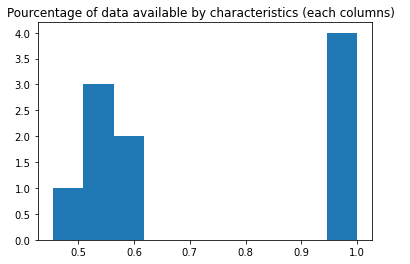

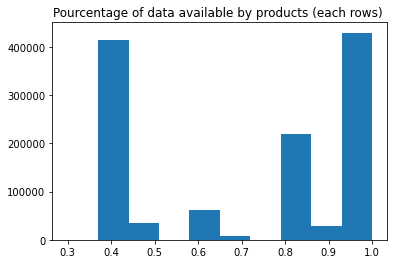

In [36]:
#Print the data available of this dataset: generale informations
x=print_row_col(0,df_charact)
y=print_row_col(1,df_charact)

### 5.1 Setting up of fruit/vegetable feature  
- **Regex** allows to find row contains the word 'legume/fruit' in the colomn "categories"  
- This selection hightlight produit contains fruit/vegetable or  an extract.
- After filtered by this selection, we have 2 features which separate fruit/vegetable to others product:
    - pnns_groups_1
    - pnns_groups_2
- Finally, I choose to use pnns_groups_1, because it's simplified version

In [37]:
#use Regex to filter by legume/fruit
cat=df_charact.categories
Fruit_df=df_charact[cat.str.contains('legume|fruit', regex=True)==True]

In [38]:
Fruit_df.shape

(47943, 10)

In [39]:
#Check what pnns_groups_1 contains
Fruit_df.pnns_groups_1.unique()

array(['Fruits and vegetables', 'Beverages', 'Sugary snacks',
       'Fat and sauces', 'Milk and dairy products', 'unknown',
       'Cereals and potatoes', 'fruits-and-vegetables', 'Composite foods',
       'sugary-snacks', 'Fish Meat Eggs', 'cereals-and-potatoes',
       'Salty snacks', nan], dtype=object)

In [40]:
#Check what pnns_groups_2 contains
Fruit_df.pnns_groups_2.unique()

array(['Fruits', 'Fruit juices', 'Vegetables', 'Dried fruits',
       'Biscuits and cakes', 'Sweetened beverages',
       'Dressings and sauces', 'Sweets', 'Soups', 'Milk and yogurt',
       'Fats', 'unknown', 'Unsweetened beverages', 'Legumes', 'fruits',
       'vegetables', 'One-dish meals', 'Artificially sweetened beverages',
       'Plant-based milk substitutes', 'Fruit nectars', 'Dairy desserts',
       'Breakfast cereals', 'pastries', 'Bread', 'Cereals', 'Meat',
       'Ice cream', 'Potatoes', 'legumes', 'Chocolate products',
       'Appetizers', 'Nuts', 'Pizza pies and quiche',
       'Pizza pies and quiches', 'Cheese', 'Salty and fatty products',
       'Alcoholic beverages', 'Fish and seafood', 'Sandwiches',
       'Teas and herbal teas and coffees', 'Processed meat'], dtype=object)

### 5.2 Creation of fruit/vegetable feature
Create a function to set if product is vegetable or not.  
Set up fruit/vegetable feature:
- 1: Few fruit/vegetable  
- 2: An average quantity of fruit/vegetable  
- 3: Mainly composed of fruit/vegetable

In [41]:
#Function which set up the fruit/vegetable feature
def select_fruit_class(val):
    
    if(val=="Fruits and vegetables" or val=="fruits-and-vegetables"):
        r=3
    elif( val=="cereals-and-potatoes" or val=="Cereals and potatoes" or val=='Beverages'):
        r=2
    else:
        r=1
        
    return r


In [42]:
#Create the new feature in df from select_fruit_class with apply to each row in 
Fruit_df["fruit_vegetable"]=Fruit_df['pnns_groups_1'].apply(lambda val: select_fruit_class(val))

<ipython-input-42-36122602b84b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Fruit_df["fruit_vegetable"]=Fruit_df['pnns_groups_1'].apply(lambda val: select_fruit_class(val))


In [43]:
#Fruit_df.fruit_vegetable.value_counts()

### 5.3 Adding fruit/vegetable feature to df_nutriscore

In [44]:
#Adding this new feature to nutriscore dataset
df_nutriscore["fruit_vegetable"]=Fruit_df["fruit_vegetable"]
#Fill 0 if nan => not fruit/vegetable
df_nutriscore["fruit_vegetable"].fillna(0, inplace=True)

In [45]:
df_nutriscore

,product_name,nutriscore_score,nutriscore_grade,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruit_vegetable
0,Vitória crackers,NaN,NaN,375.00000,1569.00000,7.00000,3.08000,70.10000,15.00000,NaN,7.80000,1.40000,0.56000,0.00000
3,moutarde au moût de raisin,18.00000,d,NaN,936.00000,8.20000,2.20000,29.00000,22.00000,0.00000,5.10000,4.60000,1.84000,0.00000
5,Sauce Sweety chili 0%,NaN,NaN,21.00000,88.00000,0.00000,0.00000,4.80000,0.40000,NaN,0.20000,2.04000,0.81600,0.00000
6,Mini coco,NaN,NaN,60.00000,251.00000,3.00000,1.00000,10.00000,3.00000,NaN,2.00000,1.15000,0.46000,0.00000
13,Salade de carottes râpées,1.00000,b,32.00000,134.00000,0.30000,0.10000,5.30000,3.90000,NaN,0.90000,0.42000,0.16800,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1555482,Minis beignets,15.00000,d,333.00000,1393.00000,20.20000,6.00000,30.90000,10.40000,NaN,7.40000,1.10000,0.44000,0.00000
1555483,Erdbeerkuchen 1019g tiefgefroren,12.00000,d,NaN,925.00000,7.60000,4.80000,35.00000,24.00000,NaN,2.60000,0.28000,0.11200,0.00000
1555484,Steak haché pur boeuf,-2.00000,a,131.00000,548.00000,5.00000,2.30000,0.00000,0.00000,NaN,21.50000,0.18000,0.07200,0.00000
1555486,Scs,NaN,NaN,100.00000,418.00000,12.00000,1.00000,2.00000,1.00000,NaN,1.00000,1.00000,0.40000,0.00000


In [46]:
df_nutriscore.shape

(1196962, 14)

### Simple analysis of data available  df_nutriscore
**Simple analysis of df_nutriscore dataset**, to get the shape of this dataset, if all data is available.
For nutriscore: 
- by characteristic (columns)
- by product (rows)

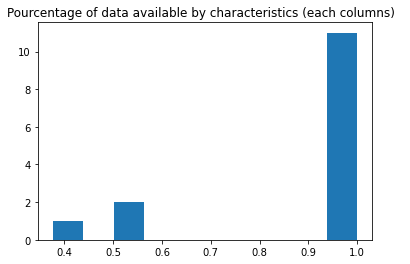

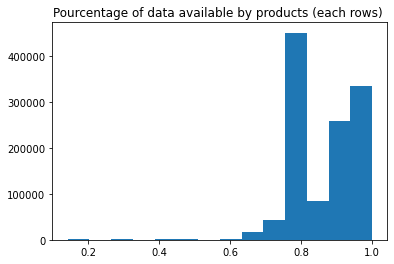

In [47]:
x=print_row_col(0,df_nutriscore)
y=print_row_col(1,df_nutriscore)

In [48]:
#x.sort_values()

In [49]:
#y.sort_values()

In [50]:
#Dropna if nutriscore_score is empty
df_nutriscore.dropna(subset=["nutriscore_score"],axis=0, inplace=True)

In [51]:
#save original index position, to use later
index_original=df_nutriscore.index
#index_original

In [52]:
df_nutriscore

,product_name,nutriscore_score,nutriscore_grade,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruit_vegetable
3,moutarde au moût de raisin,18.00000,d,NaN,936.00000,8.20000,2.20000,29.00000,22.00000,0.00000,5.10000,4.60000,1.84000,0.00000
13,Salade de carottes râpées,1.00000,b,32.00000,134.00000,0.30000,0.10000,5.30000,3.90000,NaN,0.90000,0.42000,0.16800,0.00000
21,Tarte noix de coco,14.00000,d,381.00000,1594.00000,22.00000,15.50000,27.30000,21.90000,4.40000,4.60000,0.10000,0.04000,0.00000
31,Compote de poire,-2.00000,a,157.00000,657.00000,0.00000,0.00000,36.00000,27.00000,3.60000,0.60000,0.00000,0.00000,3.00000
35,Salade de macedoine de légumes,1.00000,b,143.00000,598.00000,12.70000,1.00000,3.90000,1.00000,NaN,1.90000,0.27000,0.10800,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1555476,Mousse au chocolat noir,17.00000,d,346.00000,1448.00000,27.00000,17.00000,19.00000,18.00000,NaN,6.00000,0.19000,0.07600,0.00000
1555478,Riz parfumé,0.00000,b,351.00000,1469.00000,0.50000,0.00000,80.00000,0.00000,NaN,7.00000,0.00000,0.00000,0.00000
1555482,Minis beignets,15.00000,d,333.00000,1393.00000,20.20000,6.00000,30.90000,10.40000,NaN,7.40000,1.10000,0.44000,0.00000
1555483,Erdbeerkuchen 1019g tiefgefroren,12.00000,d,NaN,925.00000,7.60000,4.80000,35.00000,24.00000,NaN,2.60000,0.28000,0.11200,0.00000


fiber_100g           0.59747
energy-kcal_100g     0.91468
carbohydrates_100g   0.99822
saturated-fat_100g   0.99864
sugars_100g          0.99864
proteins_100g        0.99866
fat_100g             0.99866
energy_100g          0.99871
salt_100g            0.99923
sodium_100g          0.99923
product_name         1.00000
nutriscore_score     1.00000
nutriscore_grade     1.00000
fruit_vegetable      1.00000
dtype: float64

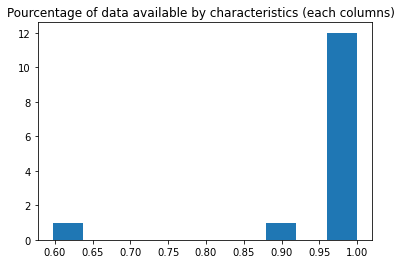

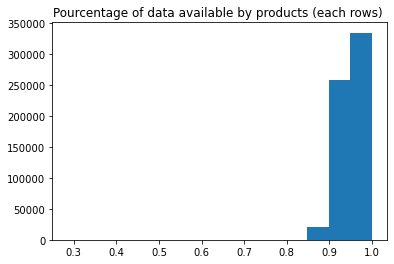

In [53]:
#Print after drop
x=print_row_col(0,df_nutriscore)
y=print_row_col(1,df_nutriscore)
x.sort_values()

In [54]:
#set index
df_impute=df_nutriscore.set_index("product_name")

In [55]:
nutrigrade=df_impute["nutriscore_grade"]
df_impute=df_impute[df_impute.columns.drop(["nutriscore_grade"])]

In [56]:
df_impute.columns

Index(['nutriscore_score', 'energy-kcal_100g', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g', 'fruit_vegetable'],
      dtype='object')

### 6. Impute NaN by Iterative Imputer

In [57]:
#Create Imputer with iterative method and train/transform our dataset, this imputer fill all na ( mainly fiber)
imputer = IterativeImputer(random_state=0)
df_imputed=imputer.fit_transform(df_impute)

In [58]:
df_imputed

array([[ 1.80000000e+01,  2.23817254e+02,  9.36000000e+02, ...,
         4.60000000e+00,  1.84000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  3.20000000e+01,  1.34000000e+02, ...,
         4.20000000e-01,  1.68000000e-01,  0.00000000e+00],
       [ 1.40000000e+01,  3.81000000e+02,  1.59400000e+03, ...,
         1.00000000e-01,  4.00000000e-02,  0.00000000e+00],
       ...,
       [ 1.50000000e+01,  3.33000000e+02,  1.39300000e+03, ...,
         1.10000000e+00,  4.40000000e-01,  0.00000000e+00],
       [ 1.20000000e+01,  2.21238728e+02,  9.25000000e+02, ...,
         2.80000000e-01,  1.12000000e-01,  0.00000000e+00],
       [-2.00000000e+00,  1.31000000e+02,  5.48000000e+02, ...,
         1.80000000e-01,  7.20000000e-02,  0.00000000e+00]])

In [59]:
#Create new dataframe with this imputed data
df_nutriscore_tmp=pd.DataFrame(data=df_imputed, columns=df_impute.columns, index=df_nutriscore['product_name'])

In [60]:
#reset index and get back "product name"
df_nutriscore=df_nutriscore_tmp.reset_index()

In [61]:
df_nutriscore

,product_name,nutriscore_score,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruit_vegetable
0,moutarde au moût de raisin,18.00000,223.81725,936.00000,8.20000,2.20000,29.00000,22.00000,0.00000,5.10000,4.60000,1.84000,0.00000
1,Salade de carottes râpées,1.00000,32.00000,134.00000,0.30000,0.10000,5.30000,3.90000,0.61845,0.90000,0.42000,0.16800,0.00000
2,Tarte noix de coco,14.00000,381.00000,1594.00000,22.00000,15.50000,27.30000,21.90000,4.40000,4.60000,0.10000,0.04000,0.00000
3,Compote de poire,-2.00000,157.00000,657.00000,0.00000,0.00000,36.00000,27.00000,3.60000,0.60000,0.00000,0.00000,3.00000
4,Salade de macedoine de légumes,1.00000,143.00000,598.00000,12.70000,1.00000,3.90000,1.00000,1.77799,1.90000,0.27000,0.10800,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
613904,Mousse au chocolat noir,17.00000,346.00000,1448.00000,27.00000,17.00000,19.00000,18.00000,0.98248,6.00000,0.19000,0.07600,0.00000
613905,Riz parfumé,0.00000,351.00000,1469.00000,0.50000,0.00000,80.00000,0.00000,6.70355,7.00000,0.00000,0.00000,0.00000
613906,Minis beignets,15.00000,333.00000,1393.00000,20.20000,6.00000,30.90000,10.40000,1.77037,7.40000,1.10000,0.44000,0.00000
613907,Erdbeerkuchen 1019g tiefgefroren,12.00000,221.23873,925.00000,7.60000,4.80000,35.00000,24.00000,1.07315,2.60000,0.28000,0.11200,0.00000


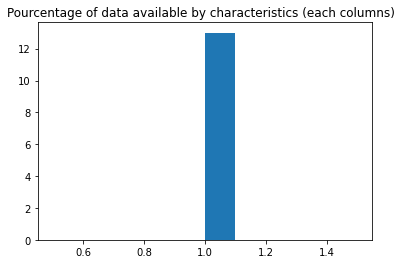

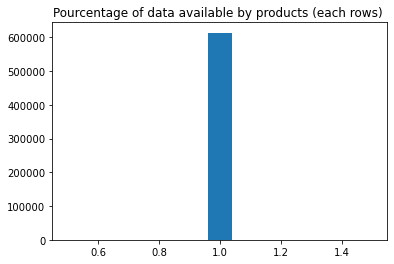

In [62]:
x=print_row_col(0,df_nutriscore)
y=print_row_col(1,df_nutriscore)

In [63]:
x.sort_values()

product_name         1.00000
nutriscore_score     1.00000
energy-kcal_100g     1.00000
energy_100g          1.00000
fat_100g             1.00000
saturated-fat_100g   1.00000
carbohydrates_100g   1.00000
sugars_100g          1.00000
fiber_100g           1.00000
proteins_100g        1.00000
salt_100g            1.00000
sodium_100g          1.00000
fruit_vegetable      1.00000
dtype: float64

In [64]:
y.sort_values()

0        1.00000
409269   1.00000
409270   1.00000
409271   1.00000
409272   1.00000
           ...  
204636   1.00000
204637   1.00000
204638   1.00000
204640   1.00000
613908   1.00000
Length: 613909, dtype: float64

## 7. Drop Aberrante value
### 7.1 Search Aberrante value

- Energy kcal max is 900.  
- Each value except for energy have a maximun of 100 and a minimun of 0.  
- The sum of all characteristic equal to 100.
- Nutriscore is between -15 and 40

In [65]:
df_nutriscore

,product_name,nutriscore_score,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruit_vegetable
0,moutarde au moût de raisin,18.00000,223.81725,936.00000,8.20000,2.20000,29.00000,22.00000,0.00000,5.10000,4.60000,1.84000,0.00000
1,Salade de carottes râpées,1.00000,32.00000,134.00000,0.30000,0.10000,5.30000,3.90000,0.61845,0.90000,0.42000,0.16800,0.00000
2,Tarte noix de coco,14.00000,381.00000,1594.00000,22.00000,15.50000,27.30000,21.90000,4.40000,4.60000,0.10000,0.04000,0.00000
3,Compote de poire,-2.00000,157.00000,657.00000,0.00000,0.00000,36.00000,27.00000,3.60000,0.60000,0.00000,0.00000,3.00000
4,Salade de macedoine de légumes,1.00000,143.00000,598.00000,12.70000,1.00000,3.90000,1.00000,1.77799,1.90000,0.27000,0.10800,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
613904,Mousse au chocolat noir,17.00000,346.00000,1448.00000,27.00000,17.00000,19.00000,18.00000,0.98248,6.00000,0.19000,0.07600,0.00000
613905,Riz parfumé,0.00000,351.00000,1469.00000,0.50000,0.00000,80.00000,0.00000,6.70355,7.00000,0.00000,0.00000,0.00000
613906,Minis beignets,15.00000,333.00000,1393.00000,20.20000,6.00000,30.90000,10.40000,1.77037,7.40000,1.10000,0.44000,0.00000
613907,Erdbeerkuchen 1019g tiefgefroren,12.00000,221.23873,925.00000,7.60000,4.80000,35.00000,24.00000,1.07315,2.60000,0.28000,0.11200,0.00000


In [66]:
#all nutriment col without energy
nutriment_col=df_nutriscore.columns.drop(['nutriscore_score', 'energy-kcal_100g', 'energy_100g','product_name','fruit_vegetable'])
#all nutriment to calculate 100g
nutriment_col_min=nutriment_col.drop(['saturated-fat_100g','sugars_100g','sodium_100g'])
print(nutriment_col)
print(nutriment_col_min)


Index(['fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g',
       'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g'],
      dtype='object')
Index(['fat_100g', 'carbohydrates_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g'],
      dtype='object')


#### Test if Nutriscore is between -15 and 40

In [67]:
#create mask to filter values
nutri_score=(df_nutriscore['nutriscore_score']>40) | (df_nutriscore['nutriscore_score']<-15)
#filtered by mask
df_nutriscore=df_nutriscore[nutri_score==False]

#### Test if each characteristics is lower than 100 and higher than 0

In [68]:
#create mask to filter values
nutri100=(df_nutriscore[nutriment_col]>100) | (df_nutriscore[nutriment_col]<0)
#for each row, look if all is False, then take it
#else if one is true, then don't take it
nutri_100=nutri100.any(axis=1)==False
#filtered by mask
df_nutriscore_1=df_nutriscore[nutri_100]

#### Test if sum of characteristics is lower than 105    
**why 105 and not 100?** because some of characteristics have 99,9 and simplify to 100, with other have 0.5%.

In [69]:
#create mask to filter values
nutrisum_100=df_nutriscore[nutriment_col_min].sum(axis=1)>105
#filtered by mask
df_nutriscore_1=df_nutriscore_1[nutrisum_100==False]

<ipython-input-69-8329e23ba4e2>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_nutriscore_1=df_nutriscore_1[nutrisum_100==False]


#### Test if:
 - energy<900
 - saturted fat<fat
 - sugar<carbohydrate
 - sodium<salt

In [70]:
#function filter aberrante values
def test_aberrante_nutri(row):
    
   
    test_aberrante=True
    
    if(row["energy-kcal_100g"]>900):
        test_aberrante=False
    
    if(row["saturated-fat_100g"]>row["fat_100g"]):
        test_aberrante=False
    
    if(row["sugars_100g"]>row["carbohydrates_100g"]):
        test_aberrante=False
    
    if(row["sodium_100g"]>row["salt_100g"]):
        test_aberrante=False
    

    return test_aberrante 

In [71]:
#Apply function to dataset
result=df_nutriscore_1.apply(test_aberrante_nutri, axis=1)

**1366 aberrante values**

In [72]:
#print how much is aberrante or not
#here is no aberrante values
#df_nutriscore_1[result==False]

In [73]:
#here is aberrante values
#df_nutriscore_1[result==True]

### 7.2 Filter by aberrante value

In [74]:
#Filtered by aberrante values
df_nutriscore_2=df_nutriscore_1[result==True]

In [75]:
#drop feature energy, it's same value that energy-kcal 100g
#drop fat, carbohydrate , sodium => values used to detect aberrantes values, but no used to create nutriscore.
df_nutriscore_2.drop(columns=["energy_100g","fat_100g","carbohydrates_100g","sodium_100g"], inplace=True)

C:\Users\Sirzesx\anaconda3\lib\site-packages\pandas\core\frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [76]:
df_nutriscore_2

,product_name,nutriscore_score,energy-kcal_100g,saturated-fat_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,fruit_vegetable
0,moutarde au moût de raisin,18.00000,223.81725,2.20000,22.00000,0.00000,5.10000,4.60000,0.00000
1,Salade de carottes râpées,1.00000,32.00000,0.10000,3.90000,0.61845,0.90000,0.42000,0.00000
2,Tarte noix de coco,14.00000,381.00000,15.50000,21.90000,4.40000,4.60000,0.10000,0.00000
3,Compote de poire,-2.00000,157.00000,0.00000,27.00000,3.60000,0.60000,0.00000,3.00000
4,Salade de macedoine de légumes,1.00000,143.00000,1.00000,1.00000,1.77799,1.90000,0.27000,0.00000
...,...,...,...,...,...,...,...,...,...
613904,Mousse au chocolat noir,17.00000,346.00000,17.00000,18.00000,0.98248,6.00000,0.19000,0.00000
613905,Riz parfumé,0.00000,351.00000,0.00000,0.00000,6.70355,7.00000,0.00000,0.00000
613906,Minis beignets,15.00000,333.00000,6.00000,10.40000,1.77037,7.40000,1.10000,0.00000
613907,Erdbeerkuchen 1019g tiefgefroren,12.00000,221.23873,4.80000,24.00000,1.07315,2.60000,0.28000,0.00000


### Nutriscore code
Take back nutricode

In [77]:
#Put back nutriscore code to nutriscore df

#create nex df 
nutrigrade_df = pd.DataFrame(nutrigrade.values, columns=['code'])
#import updated nutriscore, allow drop useless row
nutrigrade_df['nutriscore_score']=df_nutriscore_2['nutriscore_score']
nutrigrade_df.dropna(inplace=True)
nutrigrade_df

,code,nutriscore_score
0,d,18.00000
1,b,1.00000
2,d,14.00000
3,a,-2.00000
4,b,1.00000
...,...,...
613904,d,17.00000
613905,b,0.00000
613906,d,15.00000
613907,d,12.00000


In [78]:
df_nutriscore_final=df_nutriscore_2.copy();
#put back nutricode to nutriscore df
df_nutriscore_final["nutriscore_code"]=nutrigrade_df["code"]
df_nutriscore_final

,product_name,nutriscore_score,energy-kcal_100g,saturated-fat_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,fruit_vegetable,nutriscore_code
0,moutarde au moût de raisin,18.00000,223.81725,2.20000,22.00000,0.00000,5.10000,4.60000,0.00000,d
1,Salade de carottes râpées,1.00000,32.00000,0.10000,3.90000,0.61845,0.90000,0.42000,0.00000,b
2,Tarte noix de coco,14.00000,381.00000,15.50000,21.90000,4.40000,4.60000,0.10000,0.00000,d
3,Compote de poire,-2.00000,157.00000,0.00000,27.00000,3.60000,0.60000,0.00000,3.00000,a
4,Salade de macedoine de légumes,1.00000,143.00000,1.00000,1.00000,1.77799,1.90000,0.27000,0.00000,b
...,...,...,...,...,...,...,...,...,...,...
613904,Mousse au chocolat noir,17.00000,346.00000,17.00000,18.00000,0.98248,6.00000,0.19000,0.00000,d
613905,Riz parfumé,0.00000,351.00000,0.00000,0.00000,6.70355,7.00000,0.00000,0.00000,b
613906,Minis beignets,15.00000,333.00000,6.00000,10.40000,1.77037,7.40000,1.10000,0.00000,d
613907,Erdbeerkuchen 1019g tiefgefroren,12.00000,221.23873,4.80000,24.00000,1.07315,2.60000,0.28000,0.00000,d


## Save Dataset into csv

I have into other csv because it can work more efficiently with smaller dataset than bigger. (time management 4Go vs 50Mo)

In [79]:
df_charact.to_csv(r'Food_Produit_charact.csv', index = False)

In [80]:
df_nutriscore_final.to_csv(r'Food_Produit_nutriscore.csv', index = False)

## To be continued...
in others notebook, for EDA
